In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
%matplotlib inline

GPU acceleration not available, sorry
No module named 'pycuda'


In [2]:
plt.style.use('seaborn-poster')
mpl.rcParams['image.origin'] = 'lower'

In [3]:
f1 = ppy.instrument.default_m31_filters()
f2 = ppy.instrument.default_m49_filters()

In [4]:
isom1 = ppy.isochrones.Isochrone_Model(f1)
isom2 = ppy.isochrones.Isochrone_Model(f2)

In [5]:
imf1, mags1 = isom1.get_isochrone(10., 0.)
cmd1 = ppy.utils.make_pcmd(mags1)

In [6]:
imf2, mags2 = isom2.get_isochrone(10., 0.)
cmd2 = ppy.utils.make_pcmd(mags2)

In [7]:
cmd1, cmd2

(array([[12.125379, 12.007631, 11.878386, ..., 10.418937, 10.453438,
         10.48736 ],
        [ 4.584651,  4.505488,  4.420507, ..., -0.340638, -0.333483,
         -0.326288]]),
 array([[11.450067, 11.344708, 11.229275, ..., 10.546249, 10.579665,
         10.612498],
        [ 5.259963,  5.168411,  5.069618, ..., -0.46795 , -0.45971 ,
         -0.451426]]))

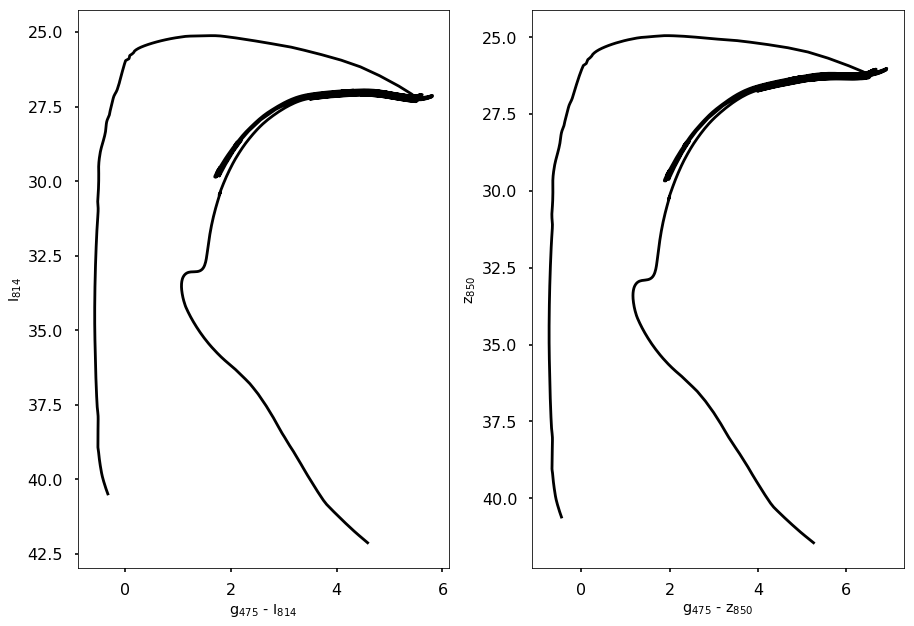

In [8]:
fig, axes = plt.subplots(ncols=2)
ppy.plotting.plot_isochrone(isom1, dmod=30., gal_model=None, axes=axes[0])
ppy.plotting.plot_isochrone(isom2, dmod=30., gal_model=None, axes=axes[1])
plt.tight_layout()

In [9]:
imf1

array([7.58611332e-02, 1.48401566e-01, 1.47444258e-01, ...,
       1.11672489e-05, 1.25511478e-05, 6.63637031e-06])

In [10]:
imf2

array([7.58611332e-02, 1.48401566e-01, 1.47444258e-01, ...,
       1.11672489e-05, 1.25511478e-05, 6.63637031e-06])

In [11]:
np.log10(17**2 * 10.**2.5)

4.960897842756548

# Variations across region?

In [12]:
regions = fits.open('../data/m49/masks/m49_chip1_thin-annuli.fits')[1].data

In [13]:
masks = {}
for i in range(1, regions.max()+1):
    masks[i] = (regions == i)

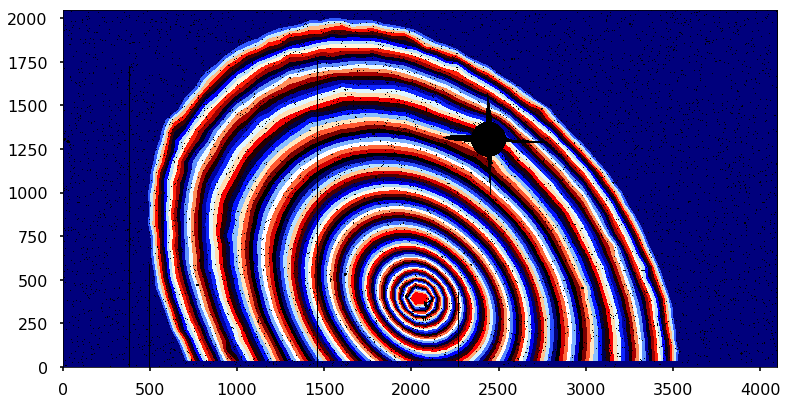

In [14]:
plt.imshow(regions, cmap='flag_r')

In [15]:
f475w = ppy.instrument.ACS_WFC_F475W(exposure=375.)
f850lp = ppy.instrument.ACS_WFC_F850LP(exposure=560.)

In [16]:
data_f475w = fits.open('../data/m49/reduced/m49_chip1_exp1_f475w_reduced.fits')['SCI'].data
data_f850lp = fits.open('../data/m49/reduced/m49_chip1_exp1_f850lp_reduced.fits')['SCI'].data

In [17]:
mags_f475w = f475w.counts_to_mag(data_f475w)
mags_f850lp = f850lp.counts_to_mag(data_f850lp)

/Users/bcook/.local/lib/python3.6/site-packages/pcmdpy/gpu_utils.py:209: RuntimeWarning: invalid value encountered in log10
  return np.log10(array_in)


In [18]:
mags = mags_f850lp
colors = mags_f475w - mags_f850lp

In [19]:
def get_pcmd(mask):
    mag = mags[mask].flatten()
    col = colors[mask].flatten()
    to_use = (~np.isnan(mag))&(~np.isnan(col))
    return np.array([mag[to_use], col[to_use]])

In [59]:
def plot_pcmd(mask, ax=None):
    pcmd = get_pcmd(mask)
    bins = [np.arange(1, 3, 0.05), np.arange(pcmd[0].min()-0.1, pcmd[0].max()+0.1, 0.05)]
    if ax is None:
        fig, ax = plt.subplots()
    plt.subplot(ax)
    plt.hist2d(pcmd[1], pcmd[0], bins=bins, norm=mpl.colors.LogNorm())
    ax.set_ylim(ax.get_ylim()[::-1])

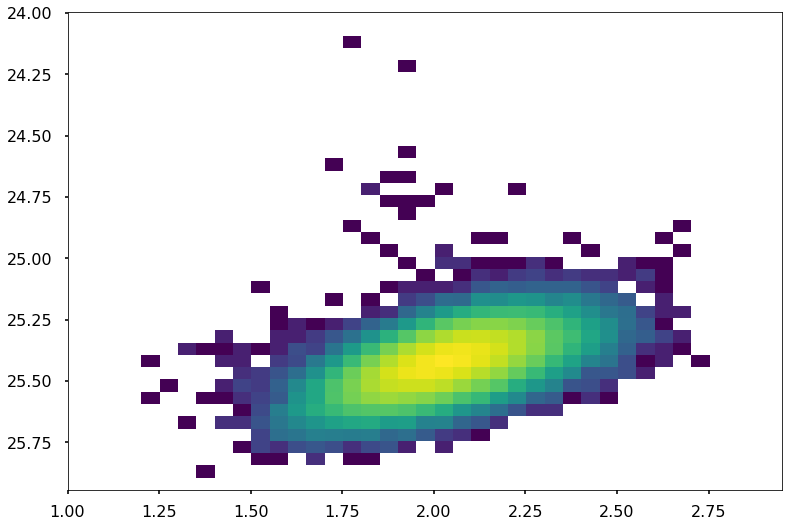

In [60]:
plot_pcmd(masks[23])

In [22]:
def plot_reg(mask, use=mags, ax=None):
    im = np.zeros_like(data_f475w)
    data = use[mask]
    im[mask] = data
    if ax is None:
        fig, ax = plt.subplots()
    plt.subplot(ax)
    plt.imshow(im, norm=mpl.colors.Normalize(vmin=np.percentile(data, 1), vmax=np.percentile(data, 99)))
    ys, xs = np.where(mask)
    ax.set_xlim([xs.min(), xs.max()])
    ax.set_ylim([ys.min(), ys.max()])
    plt.colorbar()
    return ax

In [23]:
im_test = np.ones_like(data_f475w).astype(bool)
Ys, Xs = np.where(im_test)
Ys = Ys.reshape(data_f475w.shape)
Xs = Xs.reshape(data_f475w.shape)

In [24]:
y_c = np.where(masks[99])[0].mean()
x_c = np.where(masks[99])[1].mean()
x_c, y_c

(2040.481654165822, 392.46503142104194)

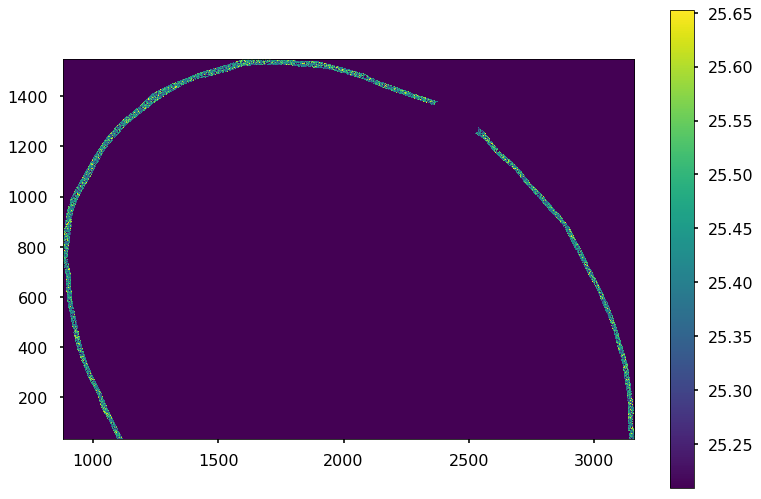

In [25]:
plot_reg(masks[23])

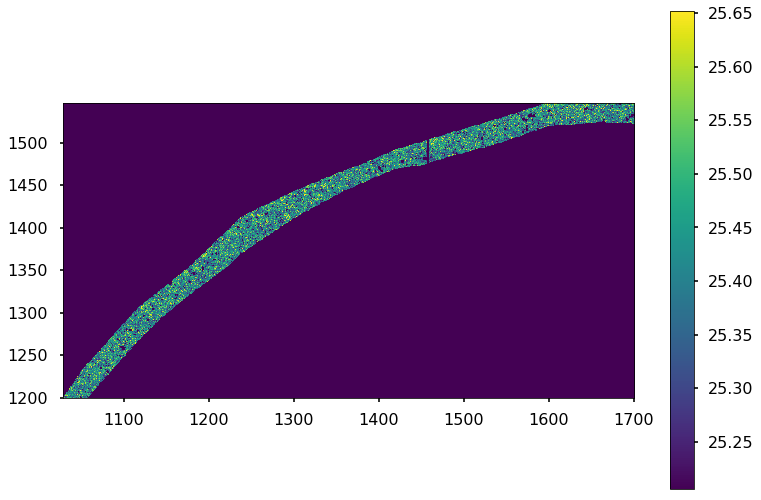

In [26]:
plot_reg(masks[23] & (Ys >= 1200) & (Xs <= 1700))

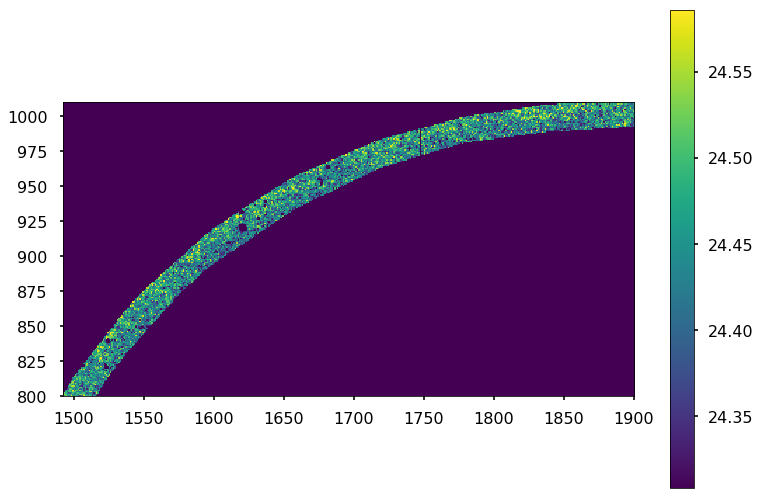

In [27]:
plot_reg(masks[48] & (Ys >= 800) & (Xs <= 1900))

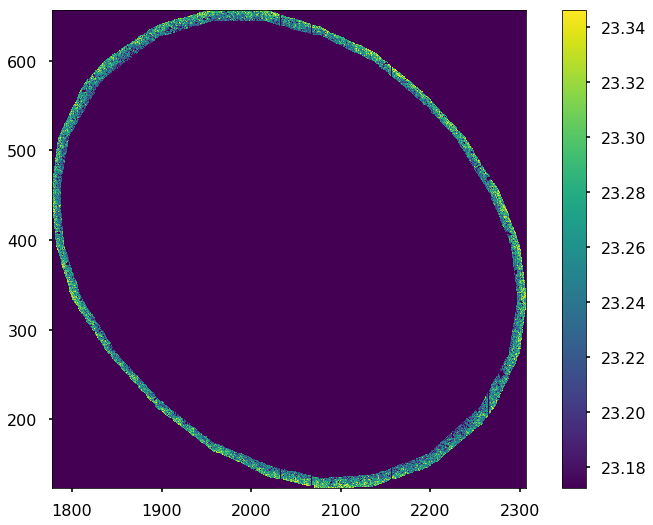

In [28]:
plot_reg(masks[70])

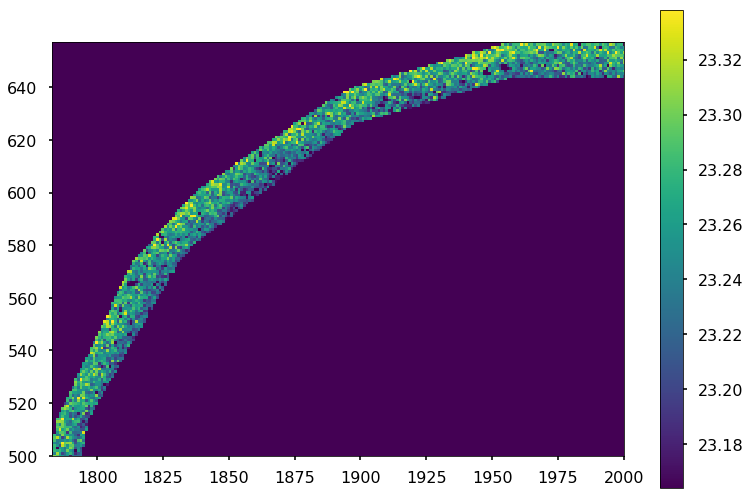

In [29]:
plot_reg(masks[70] & (Ys >= 500) & (Xs <= 2000))

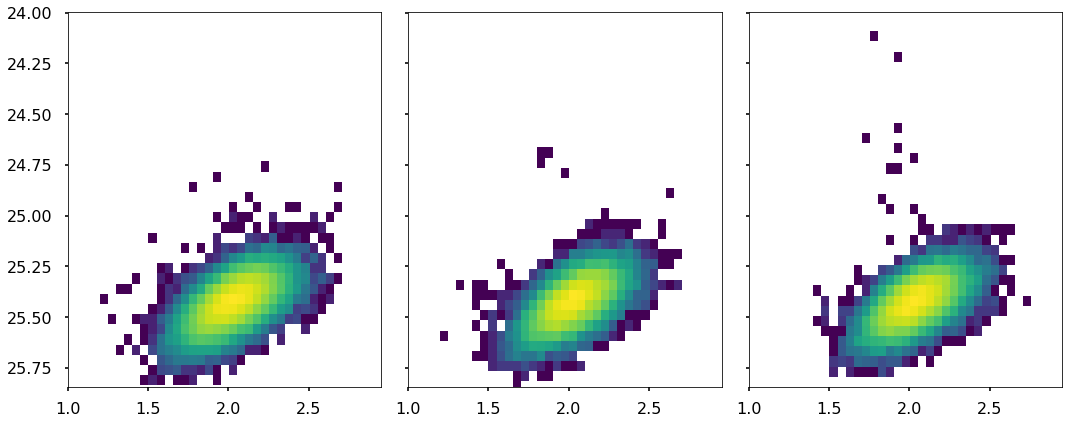

In [61]:
i = 23
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15, 6))
plot_pcmd(masks[i] & (Xs <= 1500), ax=axes[0])
plot_pcmd(masks[i] & (Xs > 1500) & (Xs <= 2500), ax=axes[1])
plot_pcmd(masks[i] & (Xs > 2500), ax=axes[2])
plt.tight_layout()

http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html

In [31]:
from numpy.linalg import eig, inv

def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

In [32]:
def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])


def ellipse_angle_of_rotation( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else:
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2

def ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

In [33]:
Rs = np.sqrt((Xs - x_c)**2 + (Ys - y_c)**2)
Thetas = np.arctan2(Ys-y_c, Xs-x_c)

In [34]:
def fit_ellipse(X, Y):
    a = fitEllipse(X, Y)
    center = ellipse_center(a)
    phi = ellipse_angle_of_rotation(a)
    axes = ellipse_axis_length(a)
    b, a = axes
    if (phi < 0.) & (a < b):
        phi += np.pi
        b, a = a, b
    if (phi <= np.pi/2.) & (b < a):
        phi = np.pi - phi
#         b, a = a,b
    r = np.sqrt(a**2 + b**2)
    a /= r
    b /= r
    return center[0], center[1], a, b, r, phi

In [35]:
def plot_ellipse(mask, ax=None):
    X, Y = Xs[mask], Ys[mask]
    cx, cy, a, b, r, phi = fit_ellipse(X, Y)
    if ax is None:
        fig, ax = plt.subplots()
    R = np.arange(0, 2*np.pi, 0.01)
    t1, t2 = a*r, b*r
    xx = cx + t1*np.cos(R)*np.cos(phi) - t2*np.sin(R)*np.sin(phi)
    yy = cy + t1*np.cos(R)*np.sin(phi) + t2*np.sin(R)*np.cos(phi)
    ax.plot(xx, yy, 'r:')
    return ax

In [36]:
def fit_and_transform(mask, x_center=None, y_center=None):
    X, Y = Xs[mask], Ys[mask]
    cx, cy, a, b, r, phi = fit_ellipse(X, Y)
    cx = x_center or cx
    cy = y_center or cy
    X_ = (X - cx)
    Y_ = (Y - cy)
    X_rot = X_*np.cos(-phi) - Y_*np.sin(-phi)
    Y_rot = Y_*np.cos(-phi) + X_*np.sin(-phi)
    r = np.sqrt((X_rot / a)**2 + (Y_rot / b)**2)
    theta = np.arctan2(Y_rot/b, X_rot/a)
    return r, theta

In [37]:
def plot_radii(mask, ax=None):
    rs, thetas = fit_and_transform(mask)
    im = np.zeros_like(Xs, dtype=float)
    im[mask] = rs
    if ax is None:
        fig, ax = plt.subplots()
    plt.subplot(ax)
    plt.imshow(im, norm=mpl.colors.Normalize(vmin=rs.min(), vmax=rs.max()))
    ys, xs = np.where(mask)
    ax.set_xlim([xs.min(), xs.max()])
    ax.set_ylim([ys.min(), ys.max()])
    plt.colorbar()
    return ax

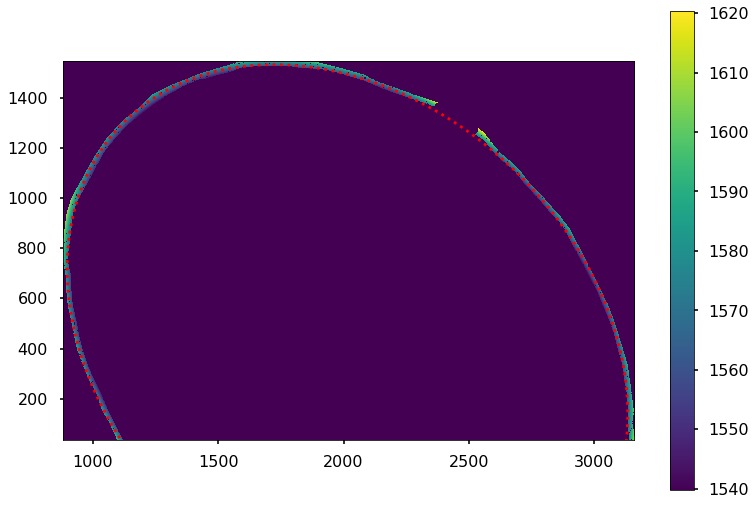

In [38]:
i = 23
ax = plot_radii(masks[i])
plot_ellipse(masks[i], ax=ax)

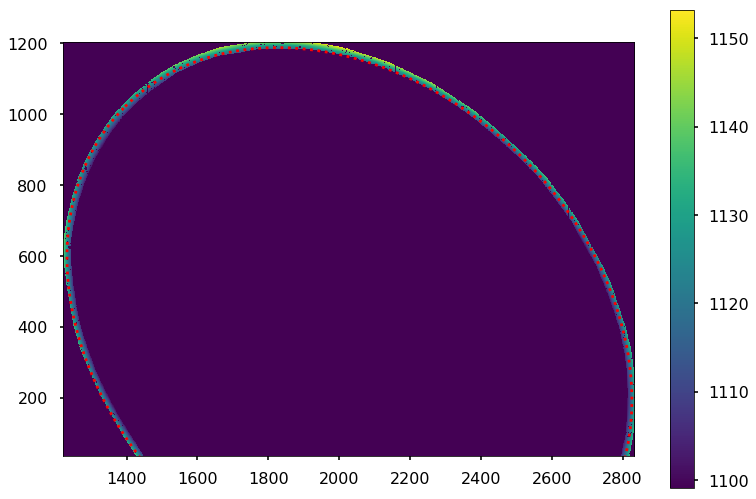

In [39]:
i = 38
ax = plot_radii(masks[i])
plot_ellipse(masks[i], ax=ax)

In [40]:
r_ellip = np.zeros_like(Xs, dtype=float) - 1.
theta_ellip = np.zeros_like(Xs, dtype=float) - 1.

for i in tqdm(range(1, 100)):
    r_ellip[masks[i]], theta_ellip[masks[i]] = fit_and_transform(masks[i])

100%|██████████| 99/99 [00:02<00:00, 42.36it/s]


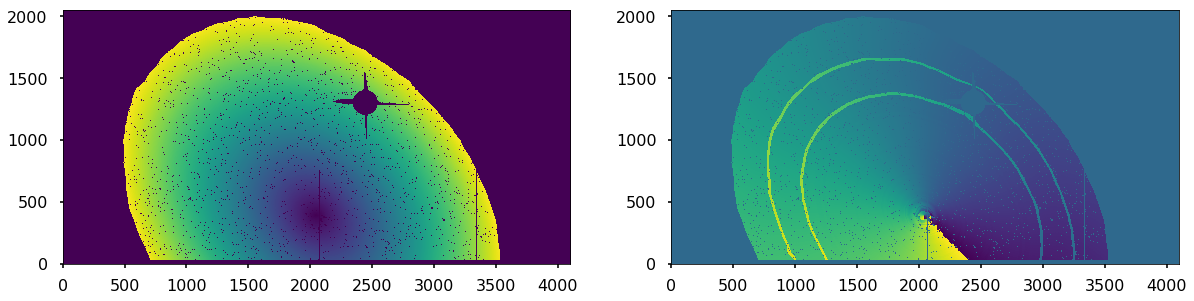

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(r_ellip)
axes[1].imshow(theta_ellip)

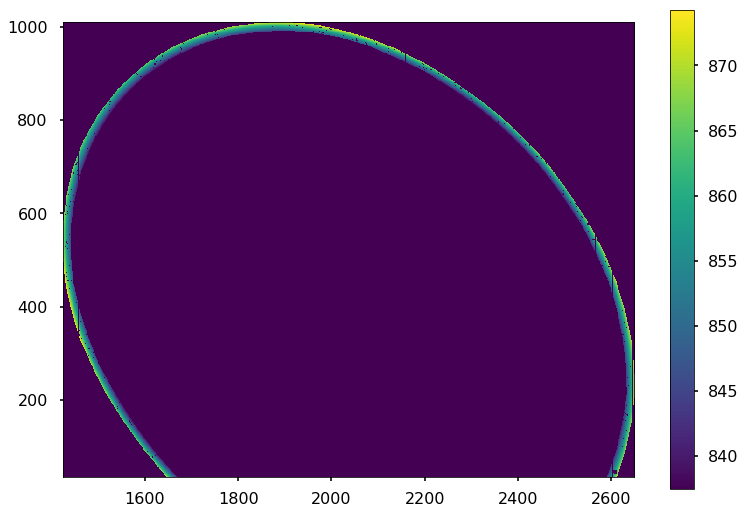

In [42]:
i = 48
ax = plot_radii(masks[i])
# plot_ellipse(masks[i], ax=ax)

(array([1296., 3838., 5922., 6431., 6458., 6454., 6501., 5473., 2701.,
         610.]), array([837.48619045, 841.15962056, 844.83305067, 848.50648078,
        852.1799109 , 855.85334101, 859.52677112, 863.20020123,
        866.87363134, 870.54706145, 874.22049156]), <a list of 10 Patch objects>)

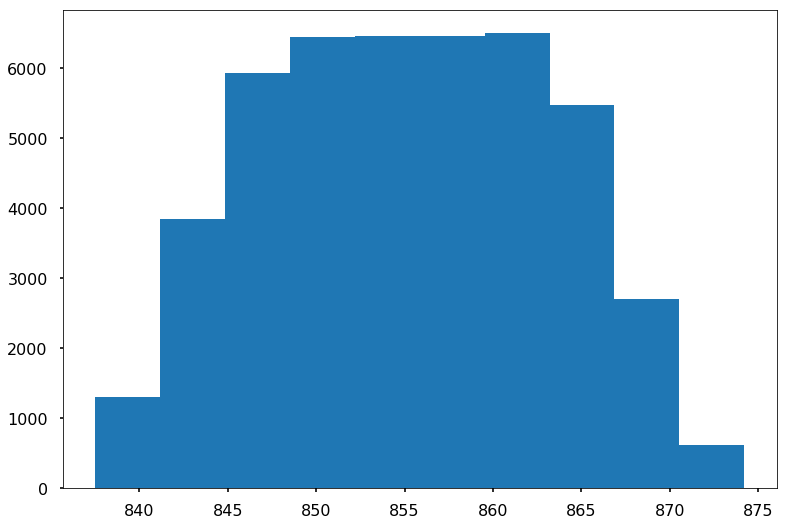

In [49]:
plt.hist(fit_and_transform(masks[48])[0])

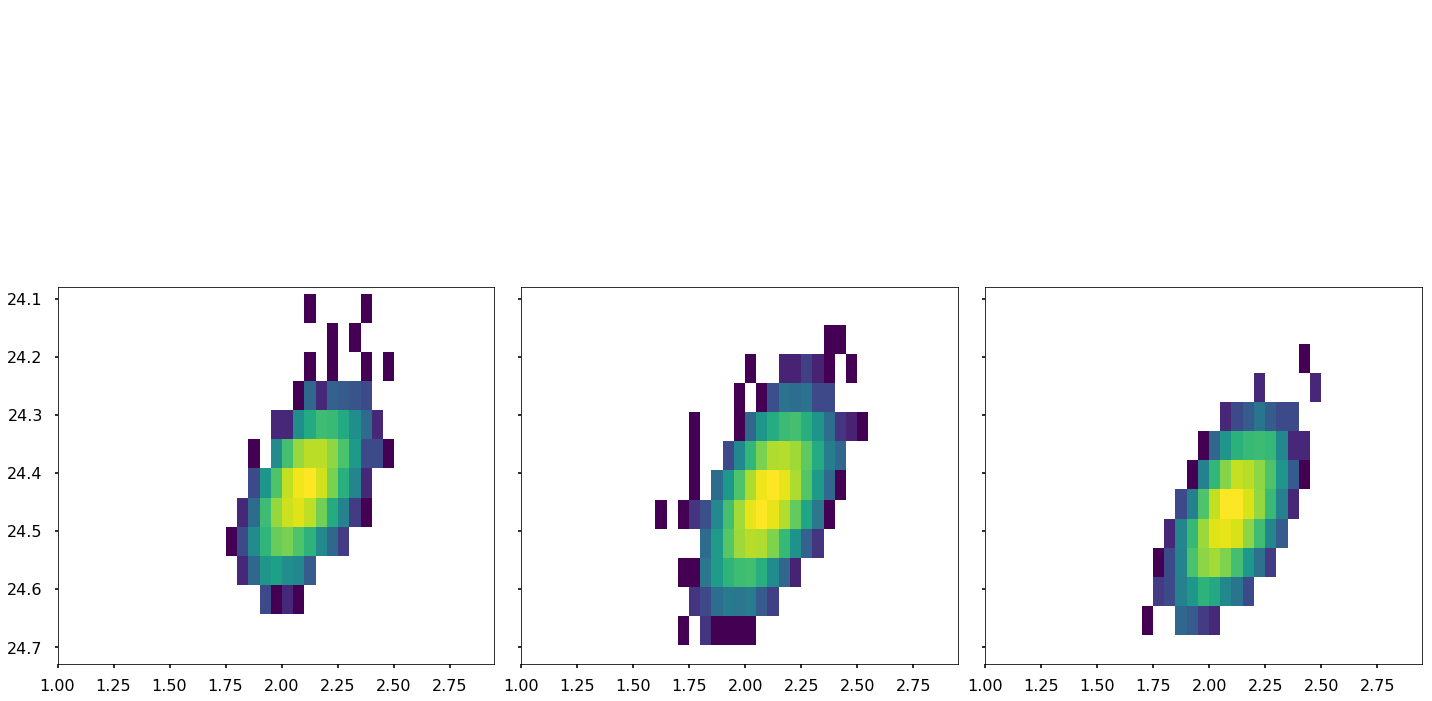

In [67]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 6), sharex=True, sharey=True)
m = masks[48]
plot_pcmd(m & (r_ellip <= 845), ax=axes[0])
plot_pcmd(m & (r_ellip > 850)&(r_ellip <= 860), ax=axes[1])
plot_pcmd(m & (r_ellip > 865), ax=axes[2])
plt.tight_layout()

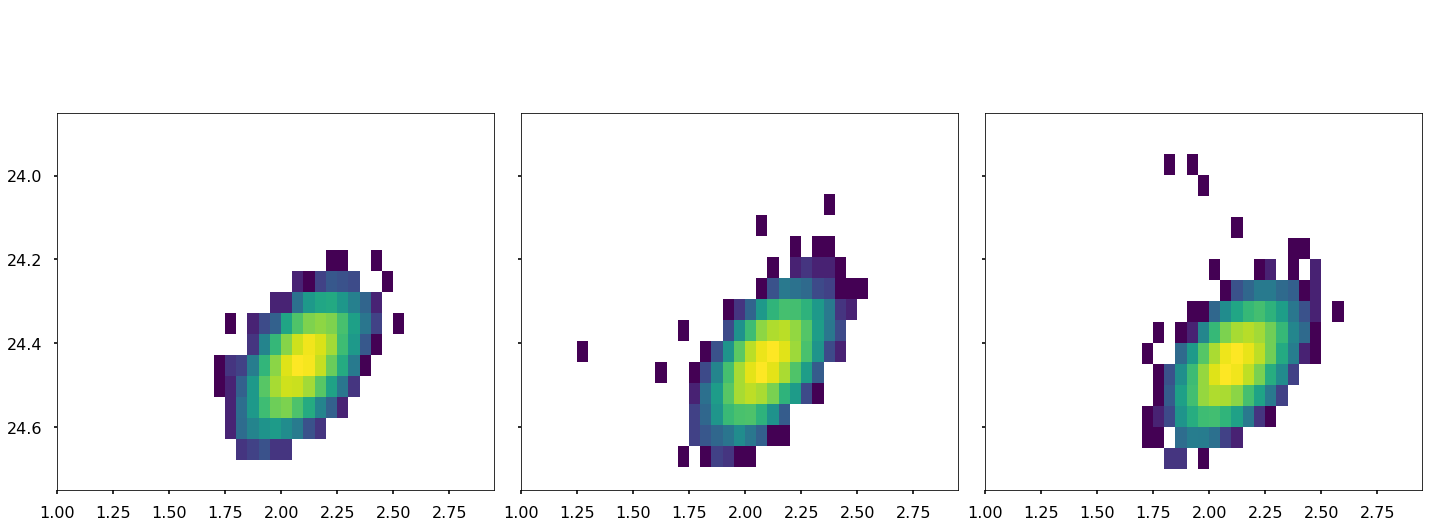

In [64]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 6), sharex=True, sharey=True)
m = masks[48]
plot_pcmd(m & (theta_ellip <= -1.5), ax=axes[0])
plot_pcmd(m & (theta_ellip > -1.5)&(theta_ellip <= 0.), ax=axes[1])
plot_pcmd(m & (theta_ellip > 0.), ax=axes[2])
plt.tight_layout()

In [68]:
get_pcmd(masks[48] & (r_ellip <= 840))[0].mean()

24.427118

In [69]:
get_pcmd(masks[48] & (r_ellip >= 870))[0].mean()

24.473907

In [46]:
pcmd_all = get_pcmd(np.ones_like(Xs).astype(bool))

In [47]:
rs_all = r_ellip[~np.isnan(mags) & ~np.isnan(colors)].flatten()

(27, 21)

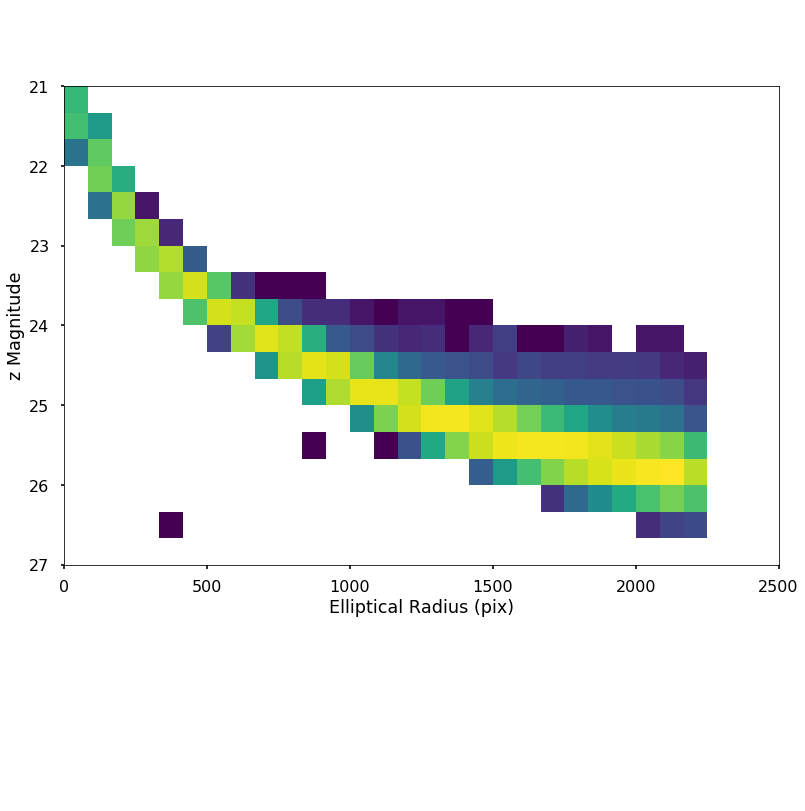

In [54]:
plt.hist2d(rs_all, pcmd_all[0], norm=mpl.colors.LogNorm(), range=((0, 2500), (20, 30)), bins=30);
plt.xlabel('Elliptical Radius (pix)')
plt.ylabel('z Magnitude')
plt.ylim([27, 21])